In [43]:
from scipy.stats.mstats import gmean
import pandas
import numpy
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn
import matplotlib.pyplot as plt


state_list = [
  "Alabama",
  "Alaska",
  "Arizona",
  "Arkansas",
  "California",
  "Colorado",
  "Connecticut",
  "Delaware",
  "District of Columbia",
  "Florida",
  "Georgia",
  "Hawaii",
  "Idaho",
  "Illinois",
  "Indiana",
  "Iowa",
  "Kansas",
  "Kentucky",
  "Louisiana",
  "Maine",
  "Maryland",
  "Massachusetts",
  "Michigan",
  "Minnesota",
  "Mississippi",
  "Missouri",
  "Montana",
  "Nebraska",
  "Nevada",
  "New Hampshire",
  "New Jersey",
  "New Mexico",
  "New York",
  "North Carolina",
  "North Dakota",
  "Ohio",
  "Oklahoma",
  "Oregon",
  "Pennsylvania",
  "Rhode Island",
  "South Carolina",
  "South Dakota",
  "Tennessee",
  "Texas",
  "Utah",
  "Vermont",
  "Virginia",
  "Washington",
  "West Virginia",
  "Wisconsin",
  "Wyoming",
]


data_1 = pandas.read_csv("CAGDP1__ALL_AREAS_2001_2020.csv", encoding="ISO-8859-1")
data_1 = data_1[data_1["Description"] == "Current-dollar GDP (thousands of current dollars)"]
data_1 = data_1[data_1["GeoName"].isin(state_list)]
data_1 = data_1.melt(id_vars=["GeoName"], value_vars=[str(i) for i in range(2001, 2020)], var_name="year",
                     value_name="gdp")
data_1 = data_1.dropna()
data_1 = data_1[data_1["gdp"] != "(NA)"]
data_1["gdp"] = data_1["gdp"].astype("int64")
data_1["year"] = data_1["year"].astype("int")
data_1.head()

,GeoName,year,gdp
0,Alabama,2001,122915468
1,Alaska,2001,28494061
2,Arizona,2001,171909621
3,Arkansas,2001,70616704
4,California,2001,1375761291


In [44]:
data_2 = pandas.read_excel("download.xls", skiprows=range(0, 5), nrows=59)
data_2["GeoName"] = data_2["GeoName"].replace("Alaska *", "Alaska")
data_2 = data_2.melt(id_vars=["GeoName"], value_vars=[str(i) for i in range(2001, 2020)], var_name="year",
                     value_name="population")
data_2["year"] = data_2["year"].astype("int")
data_2.head()

,GeoName,year,population
0,Alabama,2001,4467634
1,Alaska,2001,633714
2,Arizona,2001,5273477
3,Arkansas,2001,2691571
4,California,2001,34479458


In [45]:
data_3 = pandas.read_csv("SAIRPDImplicitRegionalPriceDeflatorsbystate.csv")
data_3 = data_3.melt(id_vars=["GeoName"], value_vars=[str(i) for i in range(2008, 2020)], var_name="year",
                     value_name="regional_deflator")
data_3["year"] = data_3["year"].astype("int")
data_3.head()


,GeoName,year,regional_deflator
0,Alabama,2008,84.664
1,Alaska,2008,100.200
2,Arizona,2008,96.960
3,Arkansas,2008,83.946
4,California,2008,103.710


In [65]:
data = pandas.merge(data_1, data_2, on=["GeoName", "year"])
data = pandas.merge(data, data_3, on=["GeoName", "year"])
data = data.rename({"GeoName": "state"}, axis=1)
data["gdp_per_capita"] = data["gdp"] / data["population"]
data["gdp_per_capita"] = data["gdp_per_capita"] / data["regional_deflator"]
data_Y0 = data[data["year"] == 2008][["state", "gdp_per_capita"]]
data = data.sort_values(["state", "year"])
data["gdp_per_capita_t-1"] = data.groupby("state")["gdp_per_capita"].shift(1)
data["gdp_per_capita_growth"] = data["gdp_per_capita"] / data["gdp_per_capita_t-1"]
data = data.dropna()
data.head()

,state,year,gdp,population,regional_deflator,gdp_per_capita,gdp_per_capita_t-1,gdp_per_capita_growth
50,Alabama,2009,170930898,4757938,83.419,0.430662,0.436903,0.985716
100,Alabama,2010,177249159,4785514,86.912,0.426163,0.430662,0.989553
150,Alabama,2011,183916641,4799642,89.186,0.429651,0.426163,1.008184
200,Alabama,2012,189245509,4816632,91.156,0.431019,0.429651,1.003186
250,Alabama,2013,194786921,4831586,92.163,0.437435,0.431019,1.014885


In [66]:
data_agg = data.groupby(by="state").agg({"gdp_per_capita_growth": [gmean]}) - 1
data_agg.columns = data_agg.columns.droplevel()
data_agg.head()

,gmean
state,
Alabama,0.008768
Alaska,-0.018166
Arizona,0.007531
Arkansas,0.006893
California,0.020571


In [76]:
data_final = pandas.merge(data_agg, data_Y0, on=["state"])
data_final["ln_gdp_per_capita"] = numpy.log(data_final["gdp_per_capita"])
data_final.head()

,state,gmean,gdp_per_capita,ln_gdp_per_capita
0,Alabama,0.008768,0.436903,-0.828044
1,Alaska,-0.018166,0.800234,-0.222852
2,Arizona,0.007531,0.431774,-0.839853
3,Arkansas,0.006893,0.413194,-0.883837
4,California,0.020571,0.512269,-0.668905


In [68]:
X = sm.add_constant(data_final)
mod = smf.ols(formula="gmean ~ ln_gdp_per_capita", data=X)
res = mod.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gmean   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     6.544
Date:                Sun, 30 Jan 2022   Prob (F-statistic):             0.0137
Time:                        21:06:10   Log-Likelihood:                 171.31
No. Observations:                  50   AIC:                            -338.6
Df Residuals:                      48   BIC:                            -334.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0011      0.003      0.312      0.756      -0.006       0.008
ln_gdp_per_capita    -0.0127      0.005     -2.558      0.014      -0.023      -0.003
==============================================================================
Omnibus:                       11.267   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               16.900
Skew:                          -0.662   Prob(JB):                     0.000214
Kurtosis:                       5.522   Cond. No.                         6.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

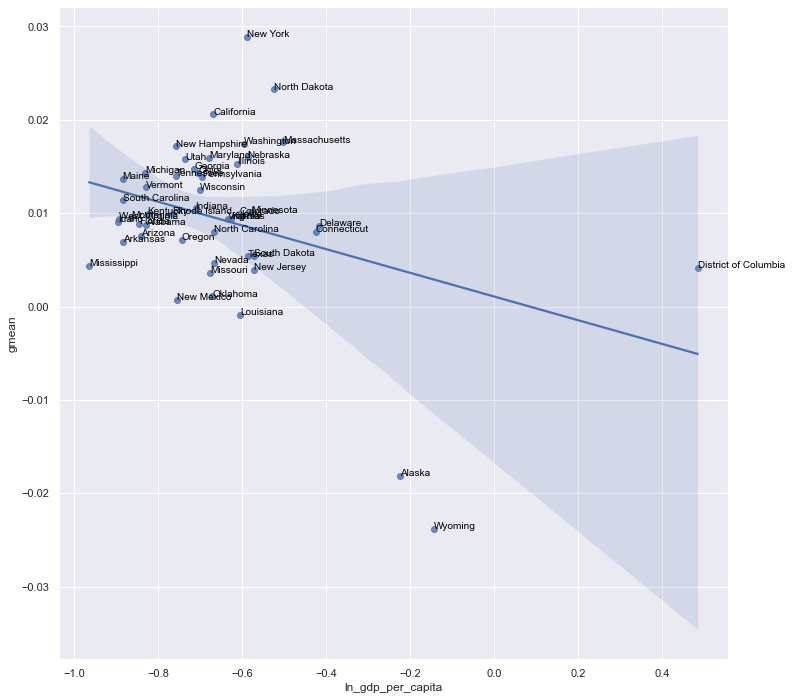

In [70]:
seaborn.set(rc={'figure.figsize':(12, 12)})
seaborn.regplot(x="ln_gdp_per_capita", y="gmean", data=data_final)
for line in range(0,data_final.shape[0]):
     plt.text(data_final.ln_gdp_per_capita[line], data_final.gmean[line], data_final.state[line], size='small', color='black')


In [77]:
data_final = data_final[~data_final["state"].isin(["Alaska", "Wyoming", "District of Columbia", "New York"])]
data_final = data_final.reset_index()
X = sm.add_constant(data_final)
mod = smf.ols(formula="gmean ~ ln_gdp_per_capita", data=X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gmean   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.3338
Date:                Sun, 30 Jan 2022   Prob (F-statistic):              0.566
Time:                        21:46:20   Log-Likelihood:                 177.67
No. Observations:                  46   AIC:                            -351.3
Df Residuals:                      44   BIC:                            -347.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0128      0.004      3.008      0.004       0.004       0.021
ln_gdp_per_capita     0.0034      0.006      0.578      0.566      -0.009       0.015
==============================================================================
Omnibus:                        0.014   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.993   Jarque-Bera (JB):                0.072
Skew:                          -0.015   Prob(JB):                        0.965
Kurtosis:                       2.809   Cond. No.                         11.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

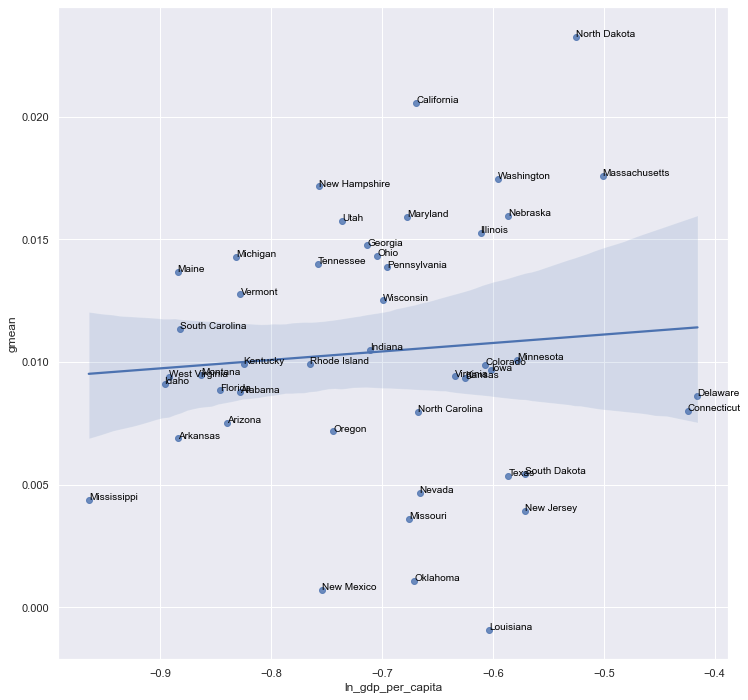

In [78]:
seaborn.set(rc={'figure.figsize':(12, 12)})
seaborn.regplot(x="ln_gdp_per_capita", y="gmean", data=data_final)
for line in range(0,data_final.shape[0]):
     plt.text(data_final.ln_gdp_per_capita[line], data_final.gmean[line], data_final.state[line], size='small', color='black')

https://link.springer.com/article/10.1007/s12197-020-09520-w
